Hi!

This notebooks presents a guide for autoencoding songs with autoenconders, as we've done in our work.

It presents a simple example (Come Together, from The Beatles), and present results with the different features that we tested.

Feel free to play with this code! (like changing the song, the parameters, digging into the code, etc)

# Imports

In [1]:
# External imports
# Module for manipulating arrays
import numpy as np

# Module for reading signals
import soundfile as sf

# Pytorch, for neural networks
import torch

# Module to handle annotations for MIR files
import mirdata

# Module for tensor manipulation, used here for unfoldings
import tensorly as tl

Now, let's import the code we need. It's organized in modules, which should group "coherent" codes in themselves.

In [2]:
# Module encapsulating the computation of features from the signal
import musicae.model.features as features

# General module for manipulating data: conversion between time, bars, frame indexes, loading of data, ...
import musicae.data_manipulation as dm

# Module for data manipulation related to neural networks
import musicae.neural_nets_utils as nn_utils

# Module defining our neural network (CNN AutoEncoder)
import musicae.convolutional as conv_ae

# Module containing our algorithm used for segmenting the autosimilarity
import musicae.autosimilarity_segmentation as as_seg

# Plotting module
from musicae.model.current_plot import *

# Loading the song, its annotations, and preparing it

Now, let's load the song (as a wav).

If you want to test in our example (Come Together, from the Beatles), you'll need to load the wav from your PC, but the rest of the data (like the annotations) will be downloaded automatically thanks to the package `mirdata`!

In that case, you need to modify the variable `path_to_beatles_dataset`, specifying where you want Betales annotation to be downloaded, and place the wav "01_-\_Come_Together.wav" in the folder "audio/11_-\_Abbey_Road/".

If you want to test on your own example, you'll need to change the variable `song_path`, and load manually your annotations (or no annotation at all if you don't need to test on the segmentation task and just visualize results).

In [3]:
path_to_beatles_dataset = 'C:/Users/amarmore/this_folder/Beatles dataset/'
beatles = mirdata.initialize('beatles', path_to_beatles_dataset)
beatles.download()

# NB: you have to place the file "01_-_Come_Together.wav" manually in the folder "audio/11_-_Abbey_Road/"
come_together = beatles.track('1101')

references_segments = beatles.load_sections(come_together.sections_path).intervals

song_path = come_together.audio_path

INFO: Downloading ['annotations'] to C:/Users/amarmore/this_folder/Beatles dataset/
INFO: [annotations] downloading The Beatles Annotations.tar.gz
INFO: C:/Users/amarmore/this_folder/Beatles dataset/annotations\The Beatles Annotations.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: 
    Unfortunately the audio files of the Beatles dataset are not available
    for download. If you have the Beatles dataset, place the contents into
    a folder called Beatles with the following structure:
        > Beatles/
            > annotations/
            > audio/
    and copy the Beatles folder to C:/Users/amarmore/this_folder/Beatles dataset/



Loading the song as signal, and estimating bars of this song (using the `madmom` external library).

In [4]:
the_signal, sampling_rate = sf.read(song_path)
bars = dm.get_bars_from_audio(song_path)

C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\test_icassp_nn\lib\site-packages\madmom\io\audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


# Autoencoding

Now, let's autoencode this song and evaluate results.

Parameters below are used to compute the tensor-spectrogram, with a fixed number of frames in each bar.

In [5]:
hop_length = 32 # Oversampling the spectrogram, to select frames which will be equally-spaced barwise.
hop_length_seconds = hop_length/sampling_rate # As bars are in seconds, we convert this hop length in seconds.
subdivision_bars = 96 # The number of frames to consider in each bar.

## Chromagram
First, let's present in details the chromagram.

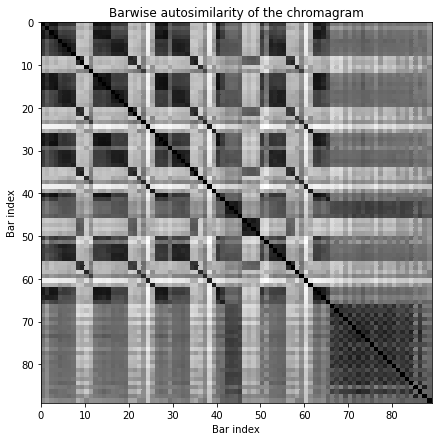

In [6]:
# Compute the chromagram. NB: PCP stands for "pitch-class profiles", which is another name for chromas.
chromagram = features.get_spectrogram(the_signal, sampling_rate, "pcp", hop_length = hop_length)
pcp_x_axis = chromagram.shape[0]

# Computing the tensor-spectrogram
chroma_tensor_barwise = nn_utils.tensorize_barwise(chromagram, bars, hop_length_seconds, subdivision_bars)

# Let's plot the barwise autosimilarity of the chromagram.
chromagram_autosimilarity = as_seg.get_autosimilarity(tl.unfold(chroma_tensor_barwise,0), transpose = True, normalize = True)
plot_me_this_spectrogram(chromagram_autosimilarity, title = "Barwise autosimilarity of the chromagram", x_axis = "Bar index", y_axis = "Bar index")

Noww we will autoencode this tensor-spectrogram.

In [7]:
# Creating a DataLoader (formatting the tensor to fit in PyTorch framework)
chroma_data_loader = nn_utils.generate_dataloader(chroma_tensor_barwise)

# Loading the neural network
conv_chroma_model = conv_ae.ConvolutionalAutoencoder(input_size_x = subdivision_bars, input_size_y = pcp_x_axis, dim_latent_space = 16)
print(conv_chroma_model)

# Optimizing the neural network
conv_chroma_model = conv_chroma_model.my_optim_method(1000, chroma_data_loader, lr=1e-3, verbose = False)

ConvolutionalAutoencoder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1152, out_features=16, bias=True)
  (i_fc): Linear(in_features=16, out_features=1152, bias=True)
  (t_conv1): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv2): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


Finally, let's visualize the results of this optimization...

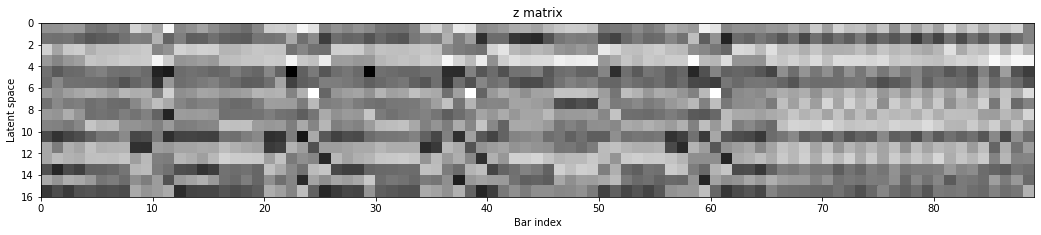

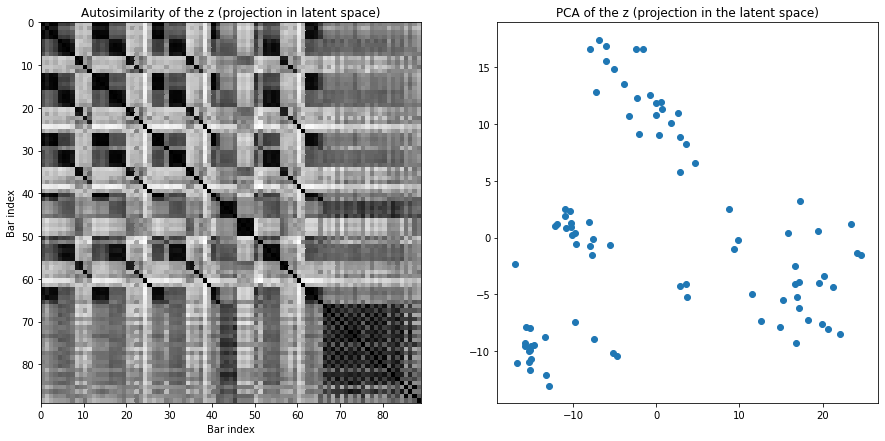

In [8]:
projection_chroma = conv_chroma_model.get_latent_projection(chroma_data_loader)
plot_latent_space(projection_chroma)

... and evaluate this projection in the segmentation framework:

In [9]:
# Compute the barwise latent projections autosimilarity
autosimilarity_chroma_projection = as_seg.get_autosimilarity(projection_chroma, transpose = True, normalize = True)

# Segmenting this autosimilarity, and extracting segmetns
segments_chroma_ae = as_seg.dynamic_convolution_computation(autosimilarity_chroma_projection, penalty_weight = 1, penalty_func = "modulo8", convolution_type = "mixed")[0]
segments_chroma_ae_in_time = dm.segments_from_bar_to_time(segments_chroma_ae, bars)

# Computing segmentation scores
score_chroma_ae_zero_five = dm.compute_score_of_segmentation(references_segments, segments_chroma_ae_in_time, window_length = 0.5)
print(f"Score with 0.5 second tolerance: Precision {score_chroma_ae_zero_five[0]}, Recall {score_chroma_ae_zero_five[1]}, F measure {score_chroma_ae_zero_five[2]}")
score_chroma_ae_three = dm.compute_score_of_segmentation(references_segments, segments_chroma_ae_in_time, window_length = 3)
print(f"Score with 3 seconds tolerance: Precision {score_chroma_ae_three[0]}, Recall {score_chroma_ae_three[1]}, F measure {score_chroma_ae_three[2]}")

Score with 0.5 second tolerance: Precision 0.4, Recall 0.6666666666666666, F measure 0.5
Score with 3 seconds tolerance: Precision 0.4, Recall 0.6666666666666666, F measure 0.5


## MFCC
Let's redo this process for MFCC

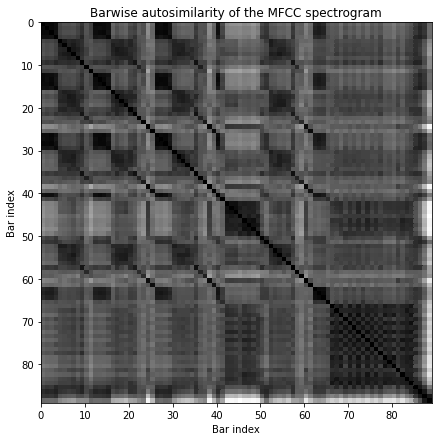

In [10]:
mfcc_gram = features.get_spectrogram(the_signal, sampling_rate, "mfcc", hop_length = hop_length, n_mfcc = 32)
mfcc_x_axis = mfcc_gram.shape[0]

mfcc_tensor_barwise = nn_utils.tensorize_barwise(mfcc_gram, bars, hop_length_seconds, subdivision_bars)
mfcc_autosimilarity = as_seg.get_autosimilarity(tl.unfold(mfcc_tensor_barwise,0), transpose = True, normalize = True)
plot_me_this_spectrogram(mfcc_autosimilarity, title = "Barwise autosimilarity of the MFCC spectrogram", x_axis = "Bar index", y_axis = "Bar index")

In [11]:
mfcc_data_loader = nn_utils.generate_dataloader(mfcc_tensor_barwise)

conv_mfcc_model = conv_ae.ConvolutionalAutoencoder(input_size_x = subdivision_bars, input_size_y = mfcc_x_axis, dim_latent_space = 16)
print(conv_mfcc_model)
conv_mfcc_model = conv_mfcc_model.my_optim_method(1000, mfcc_data_loader, lr=1e-3,verbose = False)

ConvolutionalAutoencoder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=3072, out_features=16, bias=True)
  (i_fc): Linear(in_features=16, out_features=3072, bias=True)
  (t_conv1): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv2): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


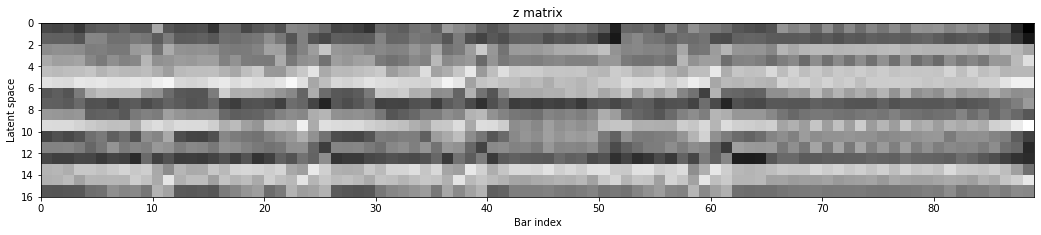

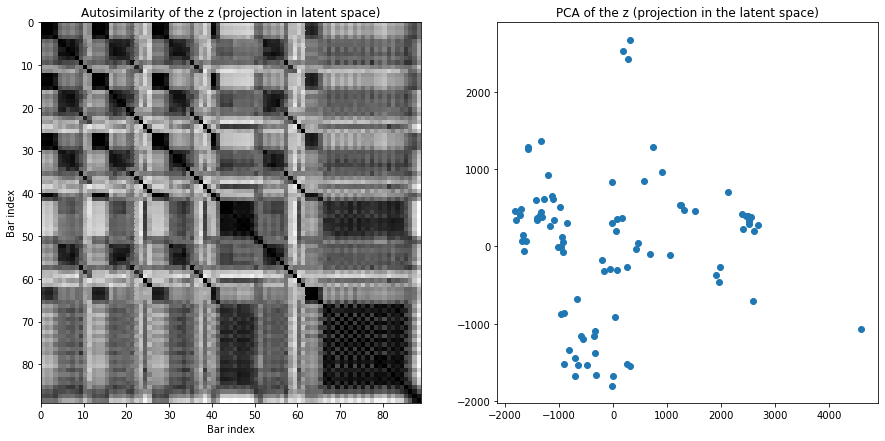

In [12]:
projection_mfcc = conv_mfcc_model.get_latent_projection(mfcc_data_loader)
plot_latent_space(projection_mfcc, labels = None)

In [13]:
autosimilarity_mfcc_projection = as_seg.get_autosimilarity(projection_mfcc, transpose = True, normalize = True)
segments_mfcc_ae = as_seg.dynamic_convolution_computation(autosimilarity_mfcc_projection, penalty_weight = 1, penalty_func = "modulo8", convolution_type = "mixed")[0]
segments_mfcc_ae_in_time = dm.segments_from_bar_to_time(segments_mfcc_ae, bars)

score_mfcc_ae_zero_five = dm.compute_score_of_segmentation(references_segments, segments_mfcc_ae_in_time, window_length = 0.5)
print(f"Score with 0.5 second tolerance: Precision {score_mfcc_ae_zero_five[0]}, Recall {score_mfcc_ae_zero_five[1]}, F measure {score_mfcc_ae_zero_five[2]}")
score_mfcc_ae_three = dm.compute_score_of_segmentation(references_segments, segments_mfcc_ae_in_time, window_length = 3)
print(f"Score with 3 seconds tolerance: Precision {score_mfcc_ae_three[0]}, Recall {score_mfcc_ae_three[1]}, F measure {score_mfcc_ae_three[2]}")

Score with 0.5 second tolerance: Precision 0.47058823529411764, Recall 0.6666666666666666, F measure 0.5517241379310345
Score with 3 seconds tolerance: Precision 0.47058823529411764, Recall 0.6666666666666666, F measure 0.5517241379310345


## Mel Spectrogram
Same process, with a Mel Spectrogram

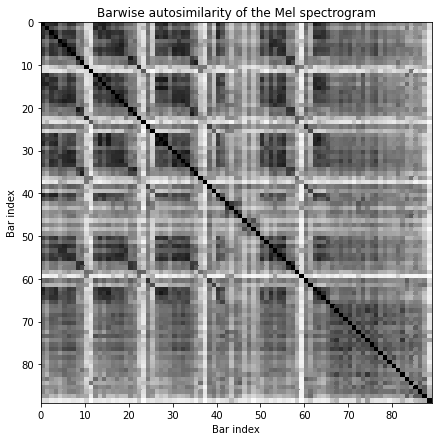

In [14]:
mel_spectrogram = features.get_spectrogram(the_signal, sampling_rate, "mel_grill", hop_length = hop_length)
mel_x_axis = mel_spectrogram.shape[0]

mel_tensor_barwise = nn_utils.tensorize_barwise(mel_spectrogram, bars, hop_length_seconds, subdivision_bars)
mel_autosimilarity = as_seg.get_autosimilarity(tl.unfold(mel_tensor_barwise,0), transpose = True, normalize = True)
plot_me_this_spectrogram(mel_autosimilarity, title = "Barwise autosimilarity of the Mel spectrogram", x_axis = "Bar index", y_axis = "Bar index")

In [15]:
mel_data_loader = nn_utils.generate_dataloader(mel_tensor_barwise)

conv_mel_model = conv_ae.ConvolutionalAutoencoder(input_size_x = subdivision_bars, input_size_y = mel_x_axis, dim_latent_space = 16)
print(conv_mel_model)
conv_mel_model = conv_mel_model.my_optim_method(1000, mel_data_loader, lr=1e-3,verbose = False)

ConvolutionalAutoencoder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=7680, out_features=16, bias=True)
  (i_fc): Linear(in_features=16, out_features=7680, bias=True)
  (t_conv1): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv2): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


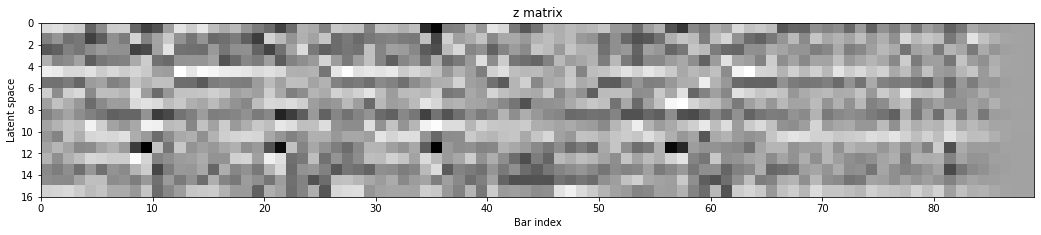

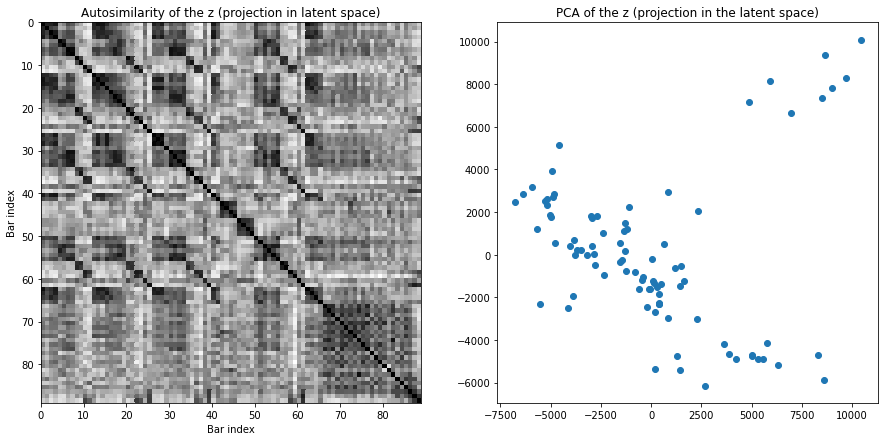

In [16]:
projection_mel = conv_mel_model.get_latent_projection(mel_data_loader)
plot_latent_space(projection_mel)

In [17]:
autosimilarity_mel_projection = as_seg.get_autosimilarity(projection_mel, transpose = True, normalize = True)
segments_mel_ae = as_seg.dynamic_convolution_computation(autosimilarity_mel_projection, penalty_weight = 1, penalty_func = "modulo8", convolution_type = "mixed")[0]
segments_mel_ae_in_time = dm.segments_from_bar_to_time(segments_mel_ae, bars)

score_mel_ae_zero_five = dm.compute_score_of_segmentation(references_segments, segments_mel_ae_in_time, window_length = 0.5)
print(f"Score with 0.5 second tolerance: Precision {score_mel_ae_zero_five[0]}, Recall {score_mel_ae_zero_five[1]}, F measure {score_mel_ae_zero_five[2]}")
score_mel_ae_three = dm.compute_score_of_segmentation(references_segments, segments_mel_ae_in_time, window_length = 3)
print(f"Score with 3 seconds tolerance: Precision {score_mel_ae_three[0]}, Recall {score_mel_ae_three[1]}, F measure {score_mel_ae_three[2]}")

Score with 0.5 second tolerance: Precision 0.42857142857142855, Recall 0.75, F measure 0.5454545454545454
Score with 3 seconds tolerance: Precision 0.42857142857142855, Recall 0.75, F measure 0.5454545454545454


## Log-Mel-spec

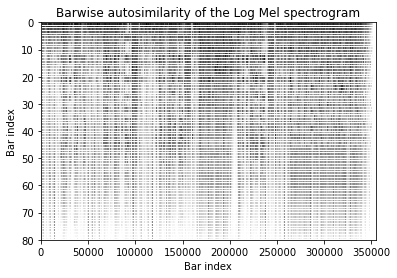

In [18]:
log_mel_spectrogram = features.get_spectrogram(the_signal, sampling_rate, "log_mel_grill", hop_length = hop_length)

log_mel_tensor_barwise = nn_utils.tensorize_barwise(log_mel_spectrogram, bars, hop_length_seconds, subdivision_bars)
log_mel_autosimilarity = as_seg.get_autosimilarity(tl.unfold(log_mel_tensor_barwise,0), transpose = True, normalize = True)

plot_me_this_spectrogram(log_mel_spectrogram, title = "Barwise autosimilarity of the Log Mel spectrogram", x_axis = "Bar index", y_axis = "Bar index")

In [19]:
log_mel_data_loader = nn_utils.generate_dataloader(log_mel_tensor_barwise)

conv_log_mel_model = conv_ae.ConvolutionalAutoencoder(input_size_x = subdivision_bars, input_size_y = mel_x_axis, dim_latent_space = 16)
print(conv_log_mel_model)
conv_log_mel_model = conv_log_mel_model.my_optim_method(1000, log_mel_data_loader, lr=1e-3,verbose = False)

ConvolutionalAutoencoder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=7680, out_features=16, bias=True)
  (i_fc): Linear(in_features=16, out_features=7680, bias=True)
  (t_conv1): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv2): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


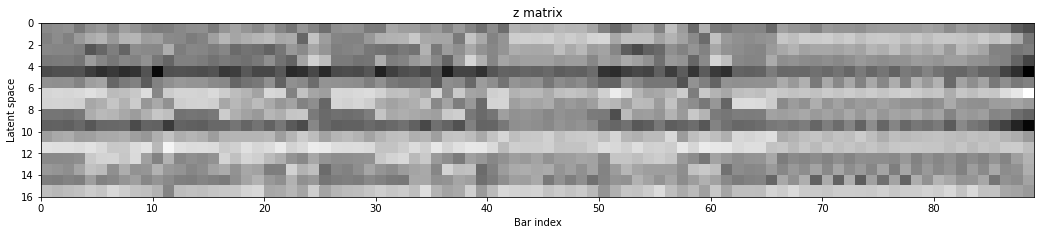

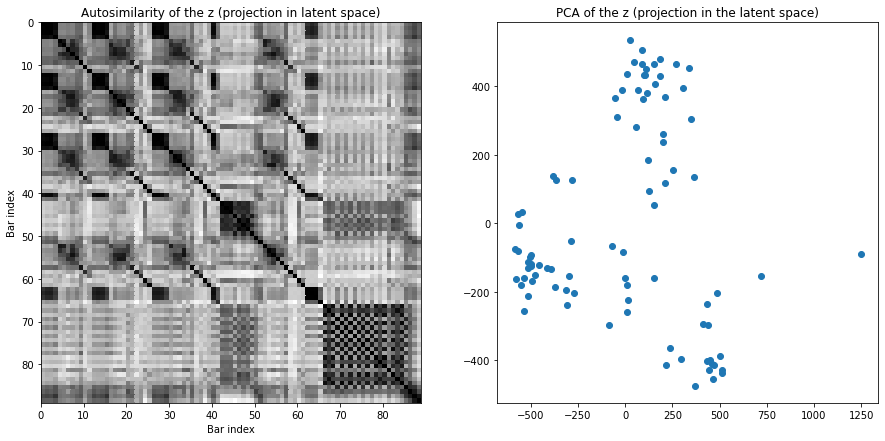

In [20]:
projection_log_mel = conv_log_mel_model.get_latent_projection(log_mel_data_loader)
plot_latent_space(projection_log_mel)

In [21]:
autosimilarity_log_mel_projection = as_seg.get_autosimilarity(projection_log_mel, transpose = True, normalize = True)
segments_log_mel_ae = as_seg.dynamic_convolution_computation(autosimilarity_log_mel_projection, penalty_weight = 1, penalty_func = "modulo8", convolution_type = "mixed")[0]
segments_log_mel_ae_in_time = dm.segments_from_bar_to_time(segments_log_mel_ae, bars)

score_log_mel_ae_zero_five = dm.compute_score_of_segmentation(references_segments, segments_log_mel_ae_in_time, window_length = 0.5)
print(f"Score with 0.5 second tolerance: Precision {score_log_mel_ae_zero_five[0]}, Recall {score_log_mel_ae_zero_five[1]}, F measure {score_log_mel_ae_zero_five[2]}")
score_log_mel_ae_three = dm.compute_score_of_segmentation(references_segments, segments_log_mel_ae_in_time, window_length = 3)
print(f"Score with 3 seconds tolerance: Precision {score_log_mel_ae_three[0]}, Recall {score_log_mel_ae_three[1]}, F measure {score_log_mel_ae_three[2]}")

Score with 0.5 second tolerance: Precision 0.5, Recall 0.75, F measure 0.6
Score with 3 seconds tolerance: Precision 0.5, Recall 0.75, F measure 0.6


# Conclusion
We've presented a tutorial for autoencoding songs, and evaluates the resulting latent projection in the structural segmentation task.

This code could, theoretically, be used for any song and any feature, modulo some adjustements in the code.

Finally, as a test conclusion, let's compare the results on the above features:

In [22]:
import pandas as pd
columns = np.array(["Precision 0.5", "Recall 0.5", "F measure 0.5","Precision 3", "Recall 3", "F measure 3"])  
tab = []
tab.append([round(score_chroma_ae_zero_five[0],5), round(score_chroma_ae_zero_five[1],5),round(score_chroma_ae_zero_five[2],5),round(score_chroma_ae_three[0],5),round(score_chroma_ae_three[1],5),round(score_chroma_ae_three[2],5)])
tab.append([round(score_mfcc_ae_zero_five[0],5), round(score_mfcc_ae_zero_five[1],5),round(score_mfcc_ae_zero_five[2],5),round(score_mfcc_ae_three[0],5),round(score_mfcc_ae_three[1],5),round(score_mfcc_ae_three[2],5)])
tab.append([round(score_mel_ae_zero_five[0],5), round(score_mel_ae_zero_five[1],5),round(score_mel_ae_zero_five[2],5),round(score_mel_ae_three[0],5),round(score_mel_ae_three[1],5),round(score_mel_ae_three[2],5)])
tab.append([round(score_log_mel_ae_zero_five[0],5), round(score_log_mel_ae_zero_five[1],5),round(score_log_mel_ae_zero_five[2],5),round(score_log_mel_ae_three[0],5),round(score_log_mel_ae_three[1],5),round(score_log_mel_ae_three[2],5)])

display(pd.DataFrame(tab, index=["Chromas", "MFCC", "Mel", "Log Mel"], columns=columns))

,Precision 0.5,Recall 0.5,F measure 0.5,Precision 3,Recall 3,F measure 3
Chromas,0.4000,0.6667,0.5000,0.4000,0.6667,0.5000
MFCC,0.4706,0.6667,0.5517,0.4706,0.6667,0.5517
Mel,0.4286,0.7500,0.5454,0.4286,0.7500,0.5454
Log Mel,0.5000,0.7500,0.6000,0.5000,0.7500,0.6000
